In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import model_param_count, plot_images
from utils import IndexedDataset, RepresentationBuffer, MeanSquareDistancesStat

import random

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as T

DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
SEED=42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(DEVICE)

cuda


## 0. Training and obtaining statists

In [3]:
from lightly.loss import BarlowTwinsLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.byol_transform import (
    BYOLView1Transform,
    BYOLView2Transform,
    MultiViewTransform
)
from lightly.transforms.utils import IMAGENET_NORMALIZE

class BarlowTwins(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def encode(self, x):
        return self.backbone(x).flatten(start_dim=1)

In [4]:
backbone = nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])
print(model_param_count(backbone))

11176512


In [5]:
CHS = 3
IMG_SIZE = (32, 32)
BS = 512

class BYOLTransformWrapped(MultiViewTransform):
        """Appends BYOL transform output with not augmented images"""
        def __init__(self, view_1_transform, view_2_transform):
                view_1_transform = view_1_transform or BYOLView1Transform()
                view_2_transform = view_2_transform or BYOLView2Transform()
                transforms = [
                        T.Compose([T.ToTensor(), T.Normalize(mean=IMAGENET_NORMALIZE["mean"], std=IMAGENET_NORMALIZE["std"])]),
                        view_1_transform, 
                        view_2_transform
                ]
                super().__init__(transforms=transforms)


transform_train = BYOLTransformWrapped( # note: this thing works only with 3
        view_1_transform=BYOLView1Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
        view_2_transform=BYOLView2Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
)

ds_train = IndexedDataset(datasets.CIFAR10(root='../data', transform=transform_train, download=True))
train_loader = DataLoader(ds_train, batch_size=BS, shuffle=True, drop_last=False)

Files already downloaded and verified


In [33]:
class LossInfoStat:
    def __init__(self, ds_size, n_epochs):
        self.loss_grad_norm_hist = torch.zeros(n_epochs, ds_size)

        self.n_epochs = n_epochs
        self.cur_epoch = 0

    def push(self, batch):
        idx, loss_grad_norm = batch

        self.loss_grad_norm_hist[self.cur_epoch, idx] = loss_grad_norm

    def inc_epoch(self):
        if self.cur_epoch == self.n_epochs: raise ValueError
        self.cur_epoch += 1

In [ ]:
# MSD experiment
import gc

NUM_EPOCHS=75

model = BarlowTwins(backbone).to(DEVICE)
criterion = BarlowTwinsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
repr_buffer = RepresentationBuffer(len(ds_train), 512)
loss_grad_tracker = LossInfoStat(len(ds_train), NUM_EPOCHS)

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for idx, x, _ in train_loader:
        model.train()
        x_orig, x0, x1 = x
        x_orig = x_orig.to(DEVICE)
        x0 = x0.to(DEVICE)
        x1 = x1.to(DEVICE)

        x0.requires_grad = True
        x1.requires_grad = True

        projection_0 = model(x0)
        projection_1 = model(x1)

        loss = criterion(projection_0, projection_1)
        total_loss += loss.detach()
        
        loss.backward()

        loss_grad_norm = torch.norm(torch.flatten(x0.grad.data + x1.grad.data, start_dim=1), dim=1).cpu()
        loss_grad_tracker.push((idx, loss_grad_norm))
        
        x0.grad = None
        x1.grad = None
        x0.requires_grad = False
        x1.requires_grad = False

        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    loss_grad_tracker.inc_epoch()

    torch.cuda.empty_cache()
    gc.collect()

    print(f"mean msd: {np.mean(loss_grad_tracker.loss_grad_norm_hist[epoch].cpu().detach().numpy()):.3f}")

In [40]:
# save tensor with msd hist for later
torch.save(loss_grad_tracker.loss_grad_norm_hist, 'loss_grad.pt')

## 1. Analysis of mean and std 

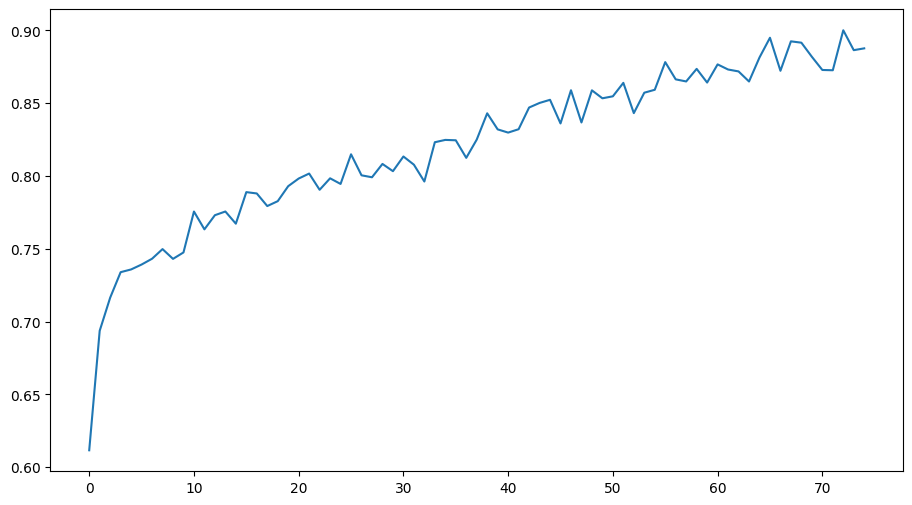

In [41]:
loss_grad_norm_hist = torch.load('loss_grad.pt')
loss_grad_norm_hist = loss_grad_tracker.loss_grad_norm_hist

plt.figure(figsize=(11, 6))
msd_hist = np.array(loss_grad_norm_hist[:NUM_EPOCHS])
plt.plot(msd_hist.mean(axis=1))
plt.show()

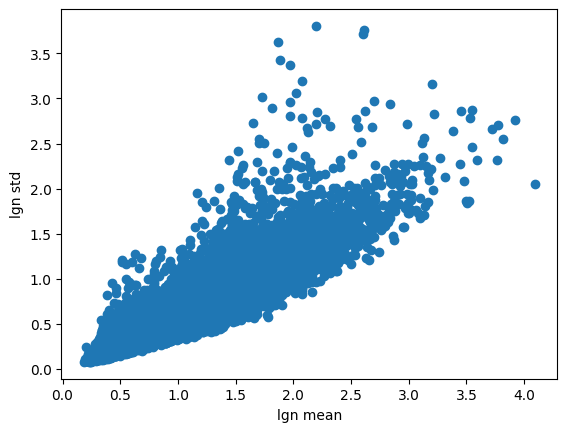

In [70]:
# mean and std of each sample msd
lgn_means = loss_grad_norm_hist.mean(axis=0)
lgn_stds = loss_grad_norm_hist.std(axis=0)

# plot scatter plot
plt.scatter(lgn_means, lgn_stds)
plt.xlabel('lgn mean')
plt.ylabel('lgn std')
plt.show()

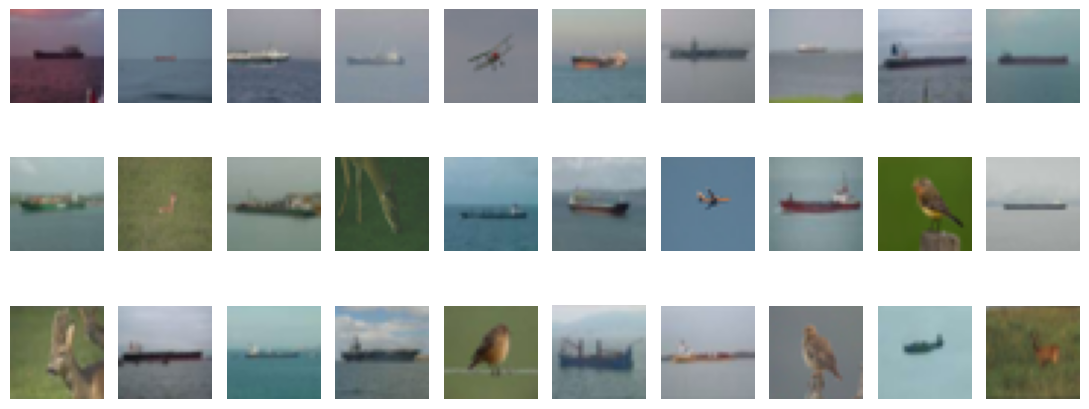

In [46]:
N=30
imgs = torch.cat([ds_train[idx][1][0].reshape(1, 3, 32, 32) for idx in np.argsort(lgn_means)[-N:]][::-1])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], n=N)

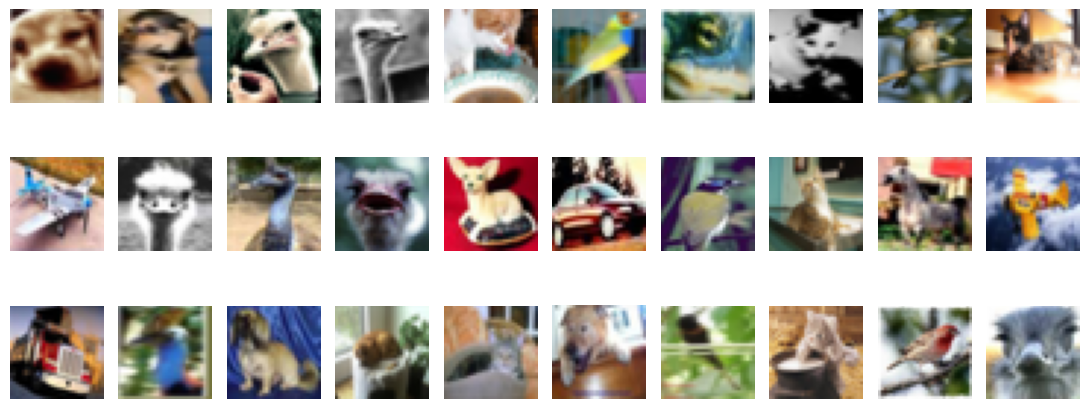

In [48]:
# images with maximum mean grad norm
N=30
imgs = torch.cat([ds_train[idx][1][0].reshape(1, 3, 32, 32) for idx in np.argsort(lgn_means)[:N]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], n=N)

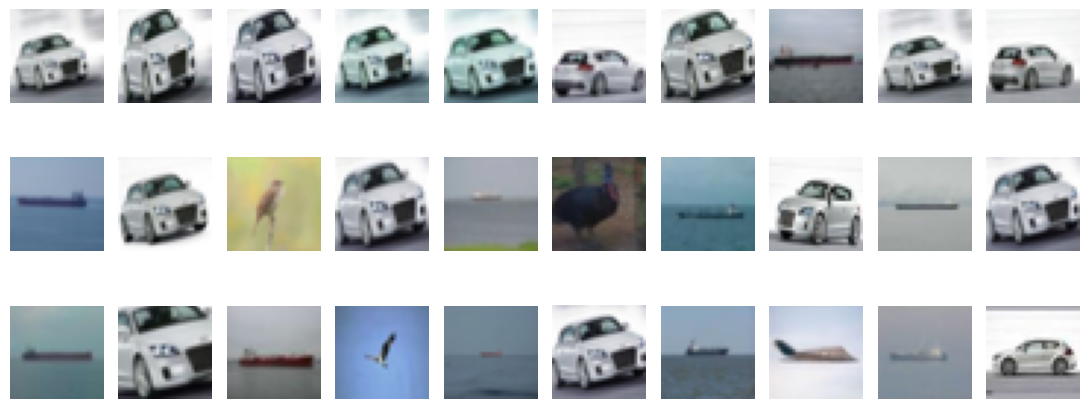

In [49]:
N=30
imgs = torch.cat([ds_train[idx][1][0].reshape(1, 3, 32, 32) for idx in np.argsort(lgn_stds)[-N:]][::-1])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], n=N)

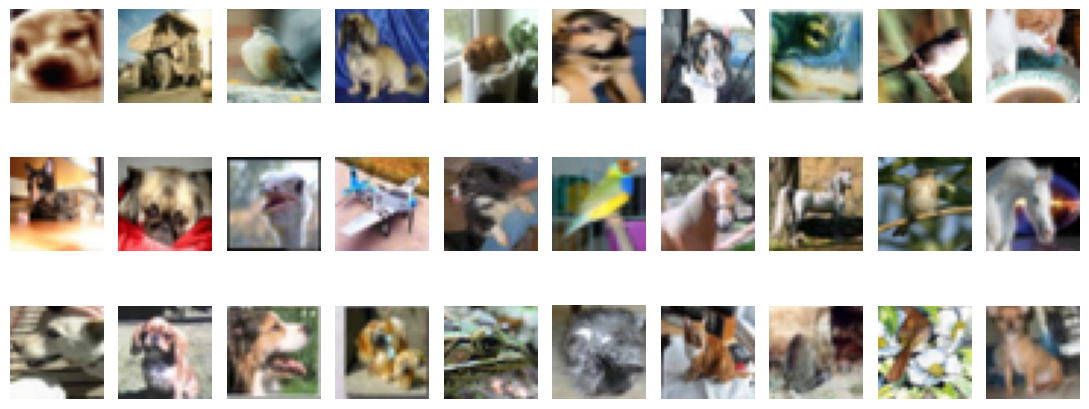

In [50]:
N=30
imgs = torch.cat([ds_train[idx][1][0].reshape(1, 3, 32, 32) for idx in np.argsort(lgn_stds)[:N]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], n=N)

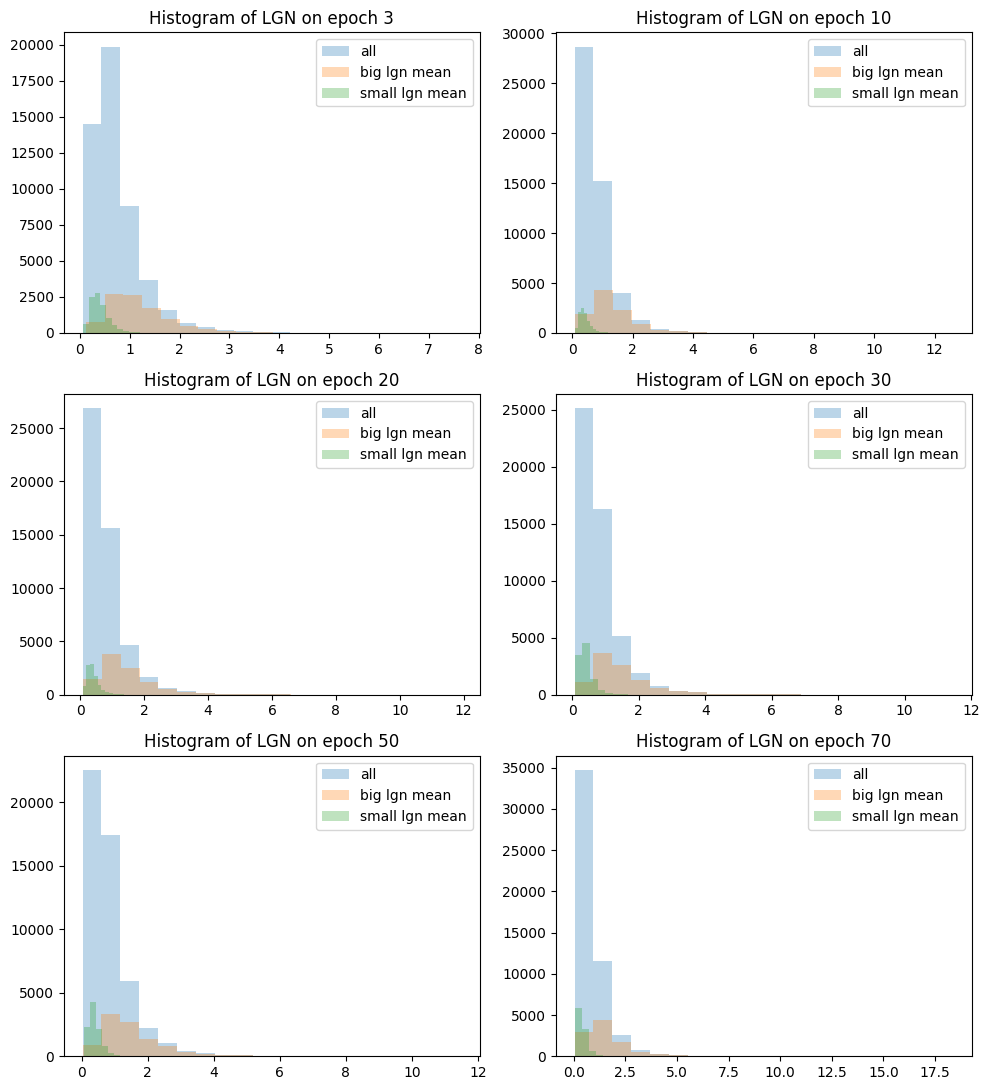

In [53]:
epochs_to_plot = [3, 10, 20, 30, 50, 70]
n_hard=10_000
n_easy=10_000
lgn_mean_big_idx = np.argsort(lgn_means)[-n_easy:]
lgn_mean_small_idx  = np.argsort(lgn_means)[:n_hard]
_, axs = plt.subplots(len(epochs_to_plot)//2, 2, figsize=(10, 11))
for idx, ax in enumerate(axs.flatten()):
    ep = epochs_to_plot[idx]
    ax.hist(msd_hist[ep, :], bins=20, alpha=0.3, label='all')
    ax.hist(msd_hist[ep, lgn_mean_big_idx], bins=20, alpha=0.3, label='big lgn mean')
    ax.hist(msd_hist[ep, lgn_mean_small_idx], bins=20, alpha=0.3, label='small lgn mean')

    ax.legend()
    ax.set_title(f"Histogram of LGN on epoch {ep}")

plt.tight_layout()
plt.show()

## 2. Add disrcepancy score

In [56]:
def lgn_discrepancy(lgn_hist, k, t='diff'):
    first_k_mean = np.mean(msd_hist[1:k+1], axis=0)
    last_k_mean = np.mean(msd_hist[-k:], axis=0)
    if t == 'ratio':
        return first_k_mean / last_k_mean
    elif t == 'diff':
        return first_k_mean - last_k_mean

disr_scores = lgn_discrepancy(loss_grad_norm_hist, k=5, t='diff')
sorted_disr_idx = np.argsort(disr_scores)

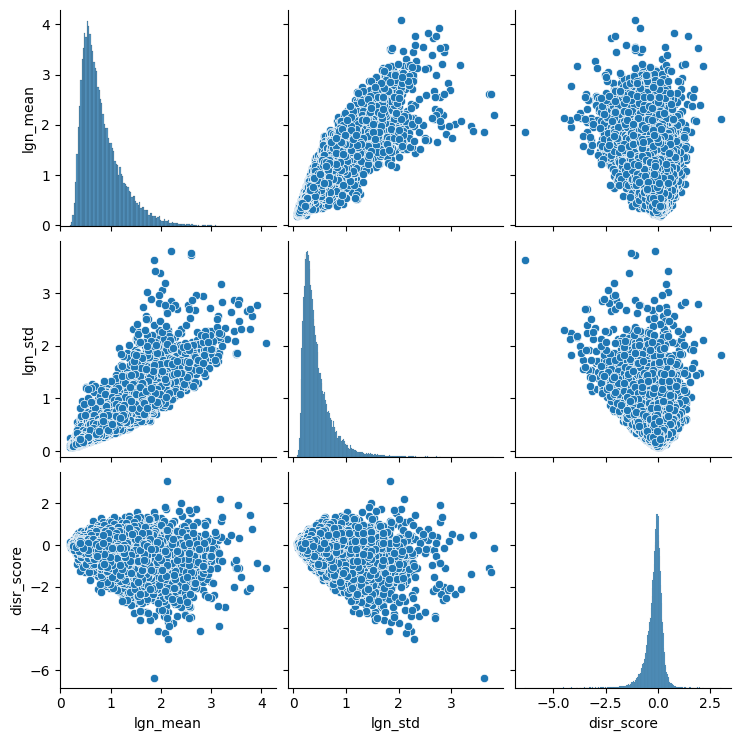

In [60]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data={'lgn_mean': lgn_means, 'lgn_std': lgn_stds, 'disr_score': disr_scores})
sns.pairplot(df, kind='scatter')
plt.show()

In [101]:
df.to_csv("loss_grad_norm_stats.csv", index=False)

In [110]:
np.corrcoef(df, rowvar=False)

array([[ 1.        ,  0.91111006, -0.39107956],
       [ 0.91111006,  1.        , -0.43148631],
       [-0.39107956, -0.43148631,  1.        ]])

## 3. Correlation with msd statistics

In [78]:
msd_stats_df = pd.read_csv('msd_statistics.csv')
msd_stats_df.drop('Unnamed: 0', axis=1, inplace=True)
msd_stats_df.head()

,msd_mean,msd_std,disr_score,cluster
0,3.279041,1.809704,4.590792,1
1,2.037585,0.434451,0.207256,1
2,4.009675,1.606036,2.567637,1
3,5.026190,1.767881,3.576884,1
4,4.029313,1.400813,2.431490,1


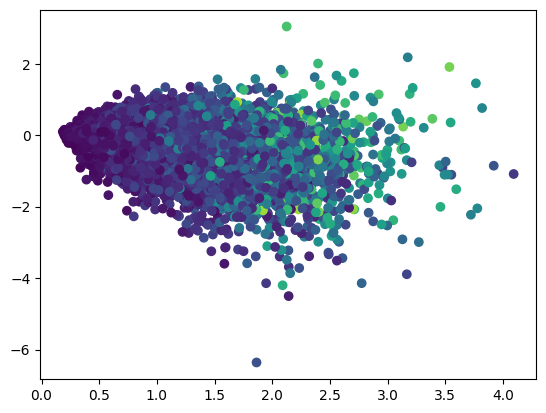

In [103]:
plt.scatter(lgn_means, disr_scores, c=msd_stats_df['msd_mean'])
plt.show()

In [88]:
np.corrcoef(lgn_means, msd_stats_df['msd_mean'])

array([[1.        , 0.67582733],
       [0.67582733, 1.        ]])

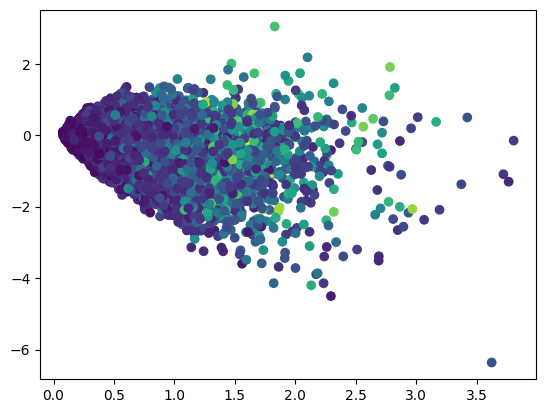

In [102]:
plt.scatter(lgn_stds, disr_scores, c=msd_stats_df['msd_mean'])
plt.show()

In [89]:
np.corrcoef(lgn_stds, msd_stats_df['msd_mean'])

array([[1.        , 0.61076384],
       [0.61076384, 1.        ]])

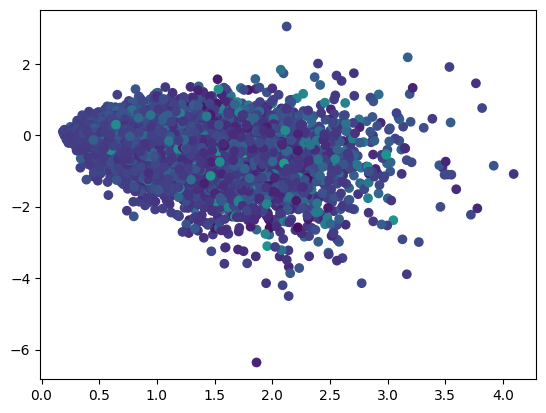

In [96]:
plt.scatter(lgn_means, disr_scores, c=msd_stats_df['disr_score'])
plt.show()

In [94]:
np.corrcoef(disr_scores, msd_stats_df['disr_score'])

array([[1.        , 0.03799528],
       [0.03799528, 1.        ]])

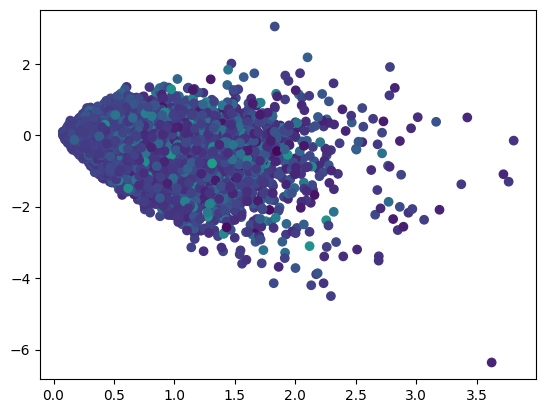

In [97]:
plt.scatter(lgn_stds, disr_scores, c=msd_stats_df['disr_score'])
plt.show()

In [93]:
np.corrcoef(lgn_stds, msd_stats_df['disr_score'])

array([[1.        , 0.04590248],
       [0.04590248, 1.        ]])

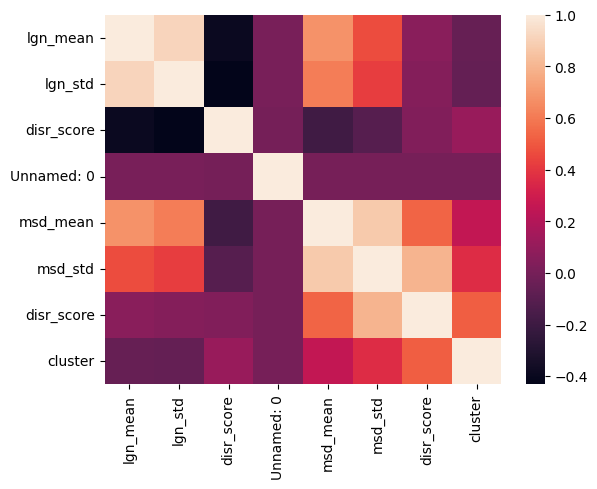

In [121]:
all_stats = pd.concat([df, msd_stats], axis=1)
labels = all_stats.columns
corr = np.corrcoef(all_stats, rowvar=False)

sns.heatmap(corr, xticklabels=labels, yticklabels=labels)
plt.show()